# This project has been implemented here: http://nameless-basin-49871.herokuapp.com/corona_search

# www.rismakov.com 

### This search engine algorithm doesn't just return a link to or a title of an article, but also returns the main points of the article and tries to extract the level of evidence that exists in the article (i.e. by observing whether peer-reviewed, number of studies, sample size, study design, etc). This allows the user to get an answer without needing to waste time reading and extracting the relevant information from within every single research paper. 

# CALL TO ACTION

In the wake of the COVID-19 pandemic, Kaggle has posted a call to action for Data Scientists and AI experts to help answer a vast list of research questions and unknowns related to the novel 2019 coronavirus. To help do so, a dataset of around 40,000 scholarly articles, compiled and prepared by the White House and a coalition of leading research groups, has been made openly available to the public. 

Given the rapidly increasing number of literature on this subject, the need to gather as much information as possible and to make sense of all the available knowledge is made much more urgent. The ability to make this process more efficient would help limit the spread of the disease and help flatten the curve.

As a method to start answering these questions and tackling the tasks posted by Kaggle’s call to action, I created a search bar tool that is able to extract the main points within the relevant articles to answer the question posed by the search query. This makes the process of gathering answers more efficient, as it limits the need to search through a vast array of articles and the need to sift through a lot of detailed information within the articles themselves.

Below I will detail how I set out to do this, as well as explain both the strengths and the limitations of the algorithm as it currently stands. 

# ABOUT NOVEL 2019 CORONAVIRUS PANDEMIC

The COVID-19 outbreak was defined as a pandemic by WHO (World Health Organization) on March 11, 2020, about 3 months after it was first identified in Wuhan, Hubei, China. 

Common symptoms of the disease include fever, cough, and shortness of breath, with complications including pneumonia and acute respiratory distress syndrome. There is currently no known vaccine.

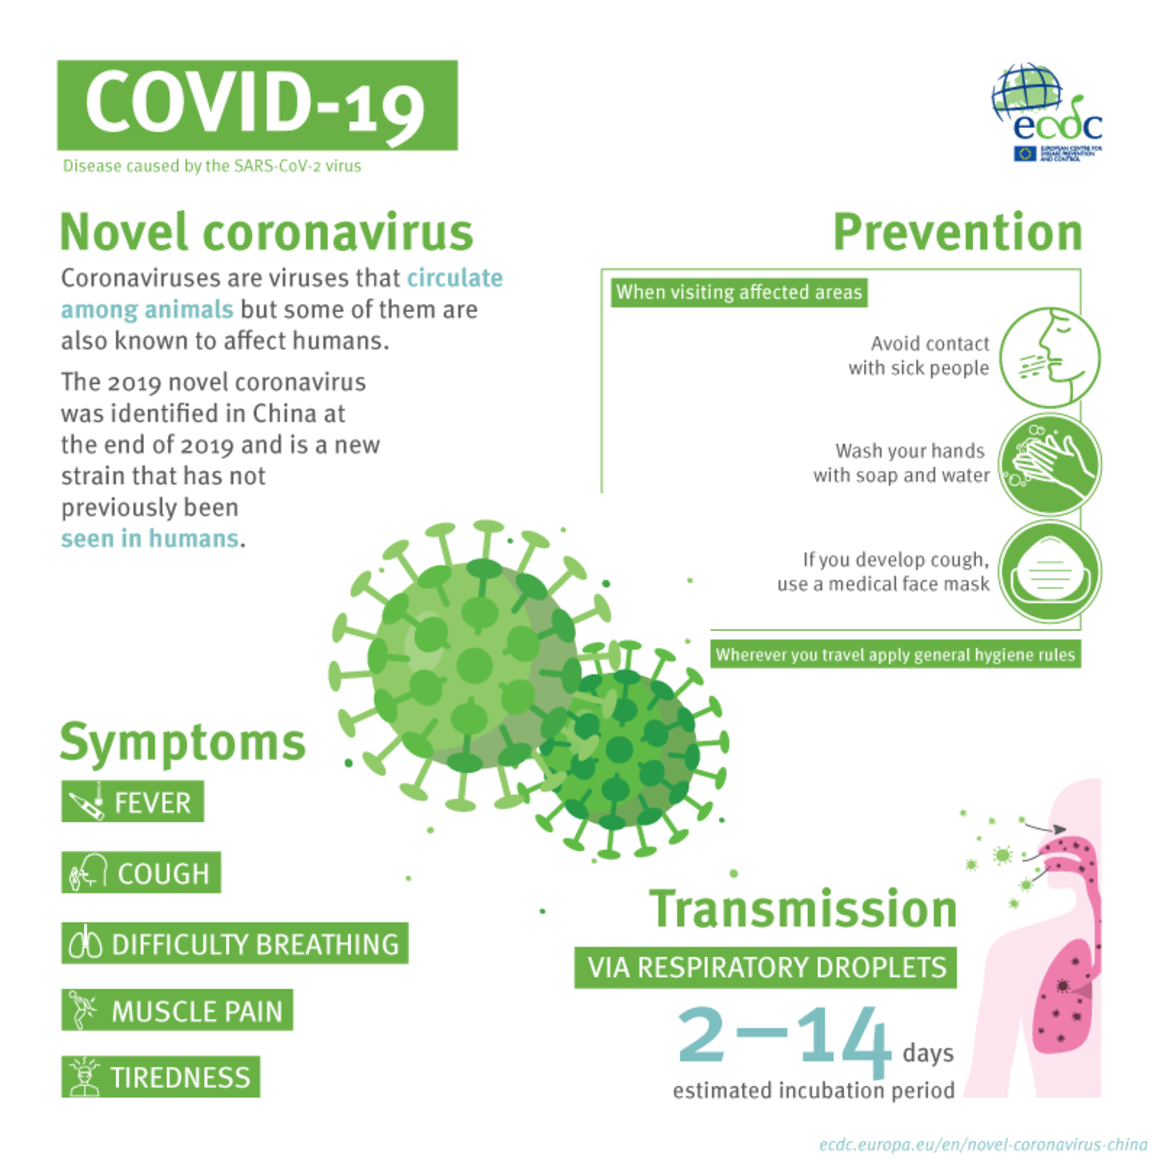

# Table of Contents

#### Creating Search Engine
- [`Article` object](#article)
- [utils functions](#utils)
- [data processing](#processing)
- [constants (stopwords)](#constants)
- [utils functions part 2](#utils2)
- [creating CBOW `Word2Vec` model](#word2vec)
- [creating `Okapi Rank25` model](#rank25)
- [`SearchQuery` object](#searchquery)
- [`Summary` object](#summary)
- [`SearchResult` object](#searchresult)
- [`StudyInfo` object](#study)
- [`ResultsHTMLText` object](#htmltext)
- [functions to extract search result](#main)

#### Testing Tasks
- [Task 1](#task1)
- [Task 2](#task2)
- [Task 3](#task3)
- [Task 4](#task4)
- [Task 5](#task5)
- [Task 6](#task6)
- [Task 7](#task7)
- [Task 8](#task8)
- [Task 9](#task9)
- [Task 10](#task10)

# Constants

In [ ]:
# maximum number of articles you want returned for each query
TOP_N_ARTICLES = 6

# maximum number of points/sentences you want returned for each article summary 
TOP_N_POINTS = 5

# path to corpus of data
CORONAVIRUS_LIBRARY_PATH = '/kaggle/input/CORD-19-research-challenge'

# path to Opaki BM25 model
BM25_MODEL_PATH = '/kaggle/input/bm25-model/bm25_model'

# path to Word2Vec model
WORD2VEC_MODEL_PATH = '/kaggle/input/word2vec-model/word2vec_model'

# path to article csv file
ARTICLE_INFO_PATH = '/kaggle/input/article-data/article_info.csv'

<a id="article"></a>
# 'Article' object

Object for storing infomation about the research article, such as title, abstract, body text, etc. 

Performs basic cleaning of the data, including removing URL links and artifacts from the text. 

In [ ]:
import re

# url links, 'doi preprint', [citations]
ARTIFACTS = r'https?:\/\/.[^\s\\]*|doi: medRxiv|preprint|\[\d+\]|\[\d+\, \d+\]'


class Article():
    '''`Article` object for storing article text information.'''

    def __init__(self, article):
        '''Initialize `Article` object.'''
        self.article = article
        
    def get_title(self):
        '''Article title.'''
        return self.article['metadata']['title']
    
    def get_abstract(self):
        '''Article abstract bodytext.'''
        return self.clean_text_of_artifacts(
            self.combine_bodytext(self.article.get('abstract', []))
        )

    def get_bodytext(self):
        '''Article main text.'''
        return self.clean_text_of_artifacts(
            self.combine_bodytext(self.article.get('body_text', []))
        )

    def get_full_text(self):
        '''Article abstract and body text.'''
        return self.get_abstract() + ' ' + self.get_bodytext()
    
    @staticmethod
    def clean_text_of_artifacts(text):
        '''Remove URL links and other artifacts from text.
        
        Parameters
        ----------
        text : str

        Returns
        -------
        str
        '''
        return re.sub(ARTIFACTS, '', text, flags=re.MULTILINE)

    @staticmethod
    def combine_bodytext(text_info):
        '''Get combined text fields from list of dicts.
        
        Parameters
        ----------
        text_info : List[Dict[str]]
            List of body text.

        Returns
        -------
        str
            `text_info` joined together into string.
        '''
        return ' '.join(x['text'] for x in text_info)


<a id="utils"></a>
# utils functions

In [ ]:
import json
import pickle
import re

from nltk.corpus import stopwords


def is_match(text, keywords):
    '''Check if any `keywords` exist in `text`.

    Parameters
    ----------
    text : str
    keywords : List[str]

    Returns
    -------
    bool
    '''
    return any(f'{keyterm} ' in text.lower() for keyterm in keywords)


def clean_text(text):
    '''Remove punctuation from query and lowercase letters.

    Parameters
    ----------
    query : str

    Returns
    -------
    str
    '''
    return re.sub('\?|!|\.|,|\(|\)', '', text).lower()


def load_json(filename):
    '''Load json file.'''
    with open(filename, 'r') as f:
        return json.load(f)


def load_model(filename):
    '''Load pickled model.'''
    return pickle.load(open(filename, 'rb'))


def save_model(model, filename):
    '''Write pickled model to file.'''
    with open(filename, 'wb') as f:
        pickle.dump(model, f)


<a id="processing"></a>
# PROCESSING THE QUERY

## DETECTING RELEVANT TERMS IN THE QUERY

One of the first tasks is having the search tool recognize and detect the relevant words in a search query. For example, in the following query:

"what is the effect of seasonality and weather on coronavirus?",

we would like the search tool to pick out ‘seasonality’ and ‘weather’ as the relevant terms to search for, as opposed to searching for ‘what’ and ‘is’, which are unlikely to lead to salient responses.

To do this, I identified the stop words within the corpus by investigating the frequency the terms appear within all the articles. Words that appeared a large amount of times were disregarded, as they were less likely to have strong relevance to the ideal search result (see: [identifying corpus-specific stop words](#stopwords)). I also included a list of general stop words from the `nltk` library.  

Additionally, we would like the search to detect similar words related to the terms used in the search. For example, when searching for ‘weather’, we would like the algorithm to also include ‘climate’ and ‘temperature’ as potentially similar words. To do this, I trained the corpus of articles to a Word2Vec model.

Words that had a high similarity score (>0.62) were included in the keywords the algorithm was searching for when iterating over the articles (see: `init_related_keywords` function in [SearchQuery object](#searchquery)).

<a id="constants"></a>
# CONSTANTS

<a id="stopwords"></a>
### identifying corpus-specific stop words

`STOPWORDS` were compiled by finding the words that appear with the highest counts within the corpus of text. Additionally, a few additional terms that were found to be less relevant were added in to the list of stopwords during testing.

📌 **PROS**:
- Specific stopwords associated with the research paper corpus (that may not be stopwords within other sets) are removed, which will increase the liklihood of the search engine not scanning for keywords that may be irrelevant for the task.

📌 **CONS**:
- This may potentially lead us to remove words that are in fact relevant, and removing them may result in relevant articles not showing up in the search results. While some words are obviously stopwords, it is hard to decide what the threshold is and to gauge on the relevancy of certain words. 

In [ ]:
import os
import pandas as pd

from collections import Counter


def get_data_corpus():
    '''Get corpus data.
    
    Returns
    -------
    str
    '''
    data = pd.read_csv(ARTICLE_INFO_PATH).loc[:, 'text']
    corpus_text = ' '.join(data.values)
    return corpus_text.replace("\n", " ")


def get_stopwords_from_corpus(corpus):
    '''Extract stopwords from corpus based on word frequency.
    
    Parameters
    ----------
    corpus : str
    
    Returns
    -------
    List[str]
    '''
    sample = corpus.lower().split(' ')

    word_counts = Counter(sample)

    max_word_count = max(word_counts.values())

    threshold = 5000
    return [word for word, count in word_counts.items() if count > threshold]


# Run once and add `stopwords` to `constants` file.
# sample = get_data_corpus()
# corpus_stopwords = get_stopwords_from_corpus(sample)


In [ ]:
CORPUS_STOPWORDS = [
    'number',
    'human',
    'cases',
    'also',
    'reported',
    'one',
    'immune',
    'response',
    'within',
    'influenza',
    'among',
    'different',
    'high',
    'found',
    'showed',
    'use',
    'identified',
    'two',
    'used',
    'results',
    'analysis',
    'performed',
    'using',
    'described',
    'detected',
    'including',
    'group',
    'could',
    'observed',
    'significant',
    'based',
    'shown',
    'however,',
    'compared',
    'higher',
    'may',
    'specific',
    'studies',
    'study',
    'type',
    'well',
    'although',
    'levels',
    'host',
    'activity',
    'data',
    'associated',
    'due',
    'samples',
    'figure',
    'table',
    'case',
    'effect', 
    'effects', 
    'affected',
    'across',
    'within',
    'humans',
    'who',
    'what',
    'why',
    'how',
    'distribution',
    'eg',
    'ie',
    'prevalence',
    'particularly',
    'whether',
    'make',
    'even',
    'might',
    '2019',
]

COVID_19_TERMS = [
    'covid-19', 
    'covid 19',
    'covid-2019',
    '2019 novel coronavirus', 
    'corona virus disease 2019',
    'coronavirus disease 19',
    'coronavirus 2019',
    '2019-ncov',
    'ncov-2019', 
    'wuhan virus',
    'wuhan coronavirus',
    'wuhan pneumonia',
    'NCIP',
    'sars-cov-2',
    'sars-cov2',
]

VIRUS_TERMS = [
    'epidemic', 
    'pandemic', 
    'viral',
    'virus',
    'viruses',
    'coronavirus', 
    'respiratory',
    'infectious',
] + COVID_19_TERMS


<a id="utils2"></a>
# utils functions (part II)

In [ ]:
from nltk.corpus import stopwords
    

def get_stopwords():
    '''Get english stopwords and corpus stopwords.''' 
    return set(VIRUS_TERMS + CORPUS_STOPWORDS + stopwords.words('english'))


<a id="word2vec"></a>
# Train gensim Word2Vec model.

Here I train a `Word2Vec` model in order to be able to extract similar keywords as the words in the search query. For example, for the query 'effects of weather on coronavirus', we would like the algorithm to also return articles related to 'climate' or 'humidity', as well as specifically 'weather'.

`Word2Vec` works by taking a large corpus of text and from it, producing a vector space. Each distinct word is embedded as a corresponding vector in the space. This allows us to see relationships betweens words and to observe which word vectors are positioned close together as a way of calculating word similarity.

![](https://i0.wp.com/migsena.com/wp-content/uploads/2017/09/word2vec.png?zoom=2.625&w=660)

📌 **PROS**:
- Being able to detect related words will allow the algorithm to find relevant results that it may have passed on otherwise (i.e. detecting articles related to 'climate' when you searched for 'weather'). 

📌 **CONS**:
- Currently, the search tool doesn't detect which term is the exact term the user typed in, and which term was been defined by the `Word2Vec` model as a similar word, and thus weighs them both the same. However, it may make more sense to weigh the exact term stronger (i.e. if you search for 'humidity', 'temperature' may be a similar word, but there are still clear differences between the two and the user may not be seeking to use them interchangably). 

In [ ]:
from gensim.models import KeyedVectors, Word2Vec 
from nltk import sent_tokenize, word_tokenize


def tokenize_sentences(sample):
    '''Tokenize sentences of text into words.
    
    Iterates through each sentence and tokenizes each sentence into words.
    
    Parameters
    ----------
    sample : str 
    
    Returns
    -------
    List[List[str]]
        sentences --> words
    ''' 
    return [
        [
            word.lower() for word in word_tokenize(sent) 
            if word not in get_stopwords()
        ] for sent in sent_tokenize(sample)
    ]


def train_word2vec_model():
    '''Train gensim Word2Vec model.
    
    Returns
    -------
    gensim.models.Word2Vec
    '''
    logging.info('Getting sample...')
    sample = get_data_corpus()
    
    logging.info('Tokenizing sample...')
    tokenized_corpus = tokenize_sentences(sample)
    
    # Create CBOW model
    logging.info('Creating Word2Vec model...')  
    model = Word2Vec(tokenized_corpus, min_count=100, size=100, window=5)
    
    model.save(WORD2VEC_MODEL_PATH)
    
    return model
    

# Run this only once.
# Open saved model instead of re-running code afterwards.

# word2vec_model = train_word2vec_model()


### install `rank_bm25` library

NOTE: turn internet on in Settings first.

In [ ]:
!pip install rank_bm25

<a id="rank25"></a>
# Train Okapi Rank25 Model.

This is the scoring/ranking similarity model I used to rank the articles by relevancy.

It works by calculating how frequently query keywords appear in a document compared to how frequently they appear in the corpus in general. For example, for the query 'what is the effect of seasonality on coronavirus', it will detect that 'seasonality' is a more relevant keyword and should be weighed more compared to terms such as 'effect' or 'coronavirus', which are likely to appear more frequently in general. Note that stop words are removed before inputted into the model, so 'is' and 'the' will be ignored.  

The formula it uses is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/43e5c609557364f7836b6b2f4cd8ea41deb86a96)

where `D` refers to the document, and `q` to the query keyword (and f(q, D) is the frequency the query term `q` appears in the document `D`).

The IDF (Inverse Document Frequency) formula is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c652b6871ce4872c8e924ff0f806bc8b06dc94ed)

where `N` is the total number of documents in the corpus, and `n(q)` is the number of documents containing the query `q`.

In [ ]:
import logging
import os
import time
import pandas as pd

from nltk.tokenize import word_tokenize 
from rank_bm25 import BM25Okapi


logging.getLogger().setLevel(logging.INFO)


def get_data():
    '''Get all research paper data in dataset.

    Returns
    -------
    pandas.DataFrame
        Includes columns ['title', 'abstract', 'text'].
    '''
    articles = []
    for dirname, _, filenames in os.walk(CORONAVIRUS_LIBRARY_PATH):
        for filename in filenames:
            full_path = os.path.join(dirname, filename)
            
            if full_path.endswith('.json'):
                article = Article(load_json(full_path))
                
                articles.append(
                    [
                        article.get_title(), 
                        article.get_abstract(), 
                        article.get_full_text(),
                        article.id
                    ]
                )
    
    return pd.DataFrame(articles, columns=['title', 'abstract', 'text', 'id'])


def add_metadata(data):
    '''Add article metadata to data.

    Parameters
    ----------
    data : pandas.DataFrame

    Returns
    -------
    pandas.DataFrame
        Returns `data` with additional meta-information.
    '''
    metadata = pd.read_csv('CORD-19-research-challenge/metadata.csv')
    data = data.join(
        metadata.set_index('sha'), on='id', how='left', rsuffix='_meta'
    )
    
    return data


def deduplicate_data(data):
    '''Remove duplicates in data.

    Parameters
    ----------
    data : pandas.DataFrame

    Returns
    -------
    pandas.DataFrame
    '''
    return data.drop_duplicates()


def filter_covid19_articles(df):
    '''Filter DataFrame on articles that contain COVID-19 keyterms.

    Parameters
    ----------
    df : pandas.DataFrame
        Article info, including 'text' column.

    Returns
    -------
    pandas.DataFrame
        Article info of COVID-19 related papers.
    '''
    return df[
        df['text'].apply(lambda x: is_match(x, set(COVID_19_TERMS)))
    ]


def tokenize_documents(corpus):
    '''Tokenize corpus of documents.
    
    Parameters
    ----------
    corpus : List[str]
        Corpus of research paper documents.
    
    Returns
    -------
    List[List[str]]
        documents --> words
    '''
    return [
        [
            word for word in word_tokenize(clean_text(doc)) 
            if word not in get_stopwords()
        ] for doc in corpus 
    ] 


def train_bm25_model(corpus):
    '''Train an Okapi BM25 model on corpus of research articles.

    Parameters
    ----------
    corpus : pandas.Series

    Returns 
    -------
    rankbm25.BM25Okapi
        Okapi BM25 model trained on corpus data.
    '''    
    logging.info('Tokenizing documents...')
    tokenized_corpus = tokenize_documents(corpus)
        
    logging.info('Training BM25 model...')
    return BM25Okapi(tokenized_corpus)


def main():
    data = get_data()
    logging.info(f'Number of articles: {len(data)}')

    # only 274 article titles containing COVID-19 terms
    # 1716 articles wirh COVID-19 terms in the text    
    data = filter_covid19_articles(data)
    logging.info(f'Number of COVID-19 articles: {len(data)}')

    data = deduplicate_data(data)
    logging.info(f'Number of COVID-19 articles: {len(data)}')

    data = add_metadata(data)
    logging.info(f'Number of COVID-19 articles: {len(data)}')

    data.to_csv(ARTICLE_INFO_PATH)

    bm25_model = train_bm25_model(data['text'])
    save_model(bm25_model, BM25_MODEL_PATH)


# Run only once and save model.

start_time = time.time()

# main()
bm25_model = load_model(BM25_MODEL_PATH)
    
seconds = time.time() - start_time
minutes = seconds / 60
print('Took {:.2f} minutes'.format(minutes))


<a id="searchquery"></a>
# 'SearchQuery' object 

This class takes in a query and processes it. Processing includes removing punctuation and stopwords, and finding similar keywords to the words within the query.

We would like the algorithm to detect similar words related to the terms used in the search. For example, when searching for ‘weather’, we would like the algorithm to also include ‘climate’ and ‘temperature’ as potentially similar words. To do this, I trained the corpus of articles to a gensim Word2Vec model.

Words that had a high similarity score (>0.62) were included in the key words the algorithm was searching for when iterating over the articles (see: `init_related_keywords` function in `SearchQuery` object below).

i.e. "what is the effect of seasonality and weather on coronavirus?" --> [
    'seasonality', 'weather', 'climate', 'rainfall', 
    'anthropogenic', 'socio-economic', 'drought', 'meteorological',
    'flooding', 'floods', 'seasonal', 'temporal', 'trends', 
    'climatic', 'pollution'
] 

In [ ]:
class SearchQuery():
    '''`SearchQuery` object for cleaning and processing a `query` input.'''

    SIMILARITY_THRESHOLD = 0.62

    def __init__(self, query):
        '''Initialize `SearchQuery` object.
        
        Parameters
        ----------
        query : str
        '''
        self.query = clean_text(query)
        self.init_query_keywords()
        self.init_related_keywords(self.get_word2vec_model())

    def init_query_keywords(self):
        '''Initialize query keywords.'''
        self.query_keywords = [
            x for x in self.query.split() if x not in get_stopwords()
        ]

    def init_related_keywords(self, word2vec_model):
        '''Initialize keywords related to `query_keywords`.

        Iterates over each keyterm in `query_keywords` and finds related words 
        from the trained `Word2Vec` vocabulary. If there's a high enough 
        similarity score, adds it to `related_keywords`.

        Parameters
        ----------
        word2vec_model : gensim.models.Word2Vec
            `Word2Vec` model trained on corpus data.  
        '''
        self.related_keywords = []
        for word in self.query_keywords:
            if word in word2vec_model.wv.vocab:
                self.related_keywords += [
                    x[0] for x in word2vec_model.wv.most_similar(word, topn=10) 
                    if x[1] > SearchQuery.SIMILARITY_THRESHOLD
                ]
    
    @staticmethod
    def get_word2vec_model():
        '''Load `Word2Vec` model previously trained on the dataset.
        
        Returns
        -------
        gensim.models.Word2Vec
        '''
        return Word2Vec.load(WORD2VEC_MODEL_PATH)


<a id="summary"></a>
# 'Summary' object

Summarizes text and outputs main points using `gensim.summarization.summarizer.summarize` function.  

`summarize` works by detecting which sentences are the most important within the text.

To not oversaturate users with too much text and too many responses to the search query, the algorithm caps the number of points that are returned per article to maximum `N`. The tool decides which points are likely to be more salient by using `gensim`'s `summarize` method.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/block_3.png)

📌 **PROS**:
- Summary allows the user to get the main points without needing to read the entire research paper (much of which may be filled with less relevant information).

📌 **CONS**:
- Summarizing the text naturally removes alot of information (much of which may potentially be relevant).

## Relevancy Filter

Added into the `Summary` object is filter that removes sentences where no keywords are present (even if they are ranked high with the `summarize` function). This is to ensure that the summary doesn't just return a high level summirization of the journal article, but that this summary is also relevant to the search query.

📌 **PROS**:
- This ensures that the user is receiving a summary relevant to his/her search query. 

📌 **CONS**
- This might lead to the summary eliminating relevant information to the research done if that information is less relevant to the search query. Just because it's less relevant to the exact query, doesn't necessarily mean it's not necessary to fully understand the results of the research article. 

Changed `relevancy_filter` to instead filter on sentences that include a numeric demical value in the text.

📌 **PROS**:
- The relevant results within research papers tend to be statistical values (percentages and p-values), so those will likely be the results we want returned and the results most likely to answer our query questions. 

📌 **CONS**
- Some research is more anecdotal or relies on different type of measures that are not necessarily numeric. This filter might not return the best results in those cases. 

In [ ]:
import re

from gensim.summarization.summarizer import summarize


class Summary():
    '''`Summary` object for extracting executive summary from text.'''
    
    def __init__(self, text, query_keywords):
        '''Initialize `Summary` object.
        
        Parameters
        ----------
        text : str
        query_keywords : List[str]
        '''
        self.text = text
        self.keywords = query_keywords

    def get_topn_sentences(self):
        '''Get top `n` sentences of text as summary.
        
        Returns
        -------
        List[str]
        '''
        ranked_sentences = summarize(self.text, split=True) 
        relevant_sentences = self.filter_relevant_sentences(ranked_sentences)

        return relevant_sentences[:TOP_N_POINTS]
    
    @staticmethod
    def is_decimal_value_in_text(text):
        '''Check if there is a decimal value or percentage within the text.

        Make sure that decimal value is not a Figure or Section number.

        Parameters
        ----------
        text : str

        Returns
        -------
        bool
        '''
        patterns = [
            r'(?<!Section )([0-9]+\.[0-9]+|%)',
            r'(?<!SECTION )([0-9]+\.[0-9]+|%)',
            r'(?<!Figure )([0-9]+\.[0-9]+|%)',
            r'(?<!FIGURE )([0-9]+\.[0-9]+|%)',
            r'(?<!Fig )([0-9]+\.[0-9]+|%)',
            r'(?<!Fig. )([0-9]+\.[0-9]+|%)',
            r'(?<!Tables )([0-9]+\.[0-9]+|%)',
            r'(?<!Chapter )([0-9]+\.[0-9]+|%)',
            r'(?<!CHAPTER )([0-9]+\.[0-9]+|%)',
        ]

        if all(re.search(pattern, text) for pattern in patterns):
            return True 
        
        return False

    def filter_relevant_sentences(self, sentences):
        '''Filter sentences on relevancy filter. 
        
        If filters out all sentences, returns original unfiltered sentences instead.
        
        NOTE: Previously was filtering on whether keyword exists in sentence. Now
        filters on whether decimal value exists in sentence.

        Parameters
        ----------
        sentences : List[str]

        Returns
        -------
        List[str]
        '''
        filtered_sentences = [
            sentence for sentence in sentences 
            if self.is_decimal_value_in_text(sentence)
        ]
        
        if not filtered_sentences:
            return sentences
        
        return filtered_sentences


<a id="searchresult"></a>
# 'SearchResult' object

Object that stores article title and top main points.


In [ ]:
class SearchResult():
    '''`SearchResult` object for storing search result article information.'''

    def __init__(self, title, text, url, query_keywords):
        '''Initialize `SearchResult` object.

        Parameters
        ----------
        title : str
            Article title.
        text : str
            Article text.
        url : str
            Article url link.
        query_keywords: List[str]
            Query search keywords.
        '''
        self.title = title
        self.text = text
        self.url = url
        self.keywords = query_keywords 

        self.main_points = self.get_topn_points()

        if isinstance(title, str):
            text = text + title
        
        self.study_info = StudyInfo(text, url)
    
    def get_topn_points(self):
        '''Keep `n` most highly ranked article points.'''
        points = Summary(self.text, self.keywords)
        
        return points.get_topn_sentences()

<a id="study"></a>
# 'StudyInfo' object

Object that extracts the level of evidence for the findings in the article.

Currently, it does this by checking if the paper is peer-reviewed. In process of adding more checks.

### Reasoning behind some of the code decision

When checking the accuracy of the `extract_sample_size_info`, I came across a couple of issues. For the example 'We aimed to obtain a minimum sample size of 20 participants from each of the three provinces, for a total sample size of over 60 participants', the function was initially capturing a sample size of 20 when the true value was at 60. I updated the function appropriately so that in these cases the total sample size would be returned. 

In [ ]:
class StudyInfo():
    '''Object for extracting the level of evidence for findings in paper.'''

    def __init__(self, article_text, url_link):
        '''Initialize `StudyInfo` object.

        Parameters
        ----------
        article_text : str
        url_link : str
        '''
        self.article_text = article_text
        self.url = url_link
        self.peer_reviewed = self.is_peer_reviewed(article_text)
        self.num_studies = self.extract_number_of_studies(article_text)
        self.sample_size = self.extract_sample_size(article_text)
        self.study_designs = self.extract_study_design(article_text) 

    @staticmethod
    def is_peer_reviewed(text):
        '''Check if paper is peer-reviewed.

        Returns
        -------
        Optional[bool]
            Returns None if unsure.
        '''
        non_peer_reviewed_clause = 'was not peer-reviewed'

        # "PMC does not include any non peer-reviewed research articles."
        peer_review_terms = {
            'peer-reviewed', 
            'peer reviewed', 
            'peer review', 
            'pubmed', 
            'ncbi', 
            'pmc',
        }

        if non_peer_reviewed_clause in text:
            return False
        elif is_match(text, peer_review_terms):
            return True

        return None

    @staticmethod
    def extract_number_of_studies(text):
        '''Extract the number of studies performed in article research.

        Does so by searching for the term 'studies' and returning the numeric 
        value right before it.
        
        Parameters
        ----------
        text : str

        Returns
        -------
        Optional[int]
            Returns None if no match found.
        '''
        pattern = r'(?:([0-9])[a-zA-Z ]{0,5}(?:studies))'

        m = re.search(pattern, text)
        if m:
            return int(m.group(1))

    @staticmethod
    def extract_sample_size(text):
        '''Extract the sample size of the article research.

        Does so by searching for the term 'sample size of' and returning the 
        numeric value right after it.
        
        Parameters
        ----------
        text : str

        Returns
        -------
        Optional[int]
            Returns None if no match found.
        '''
        pattern1 = r'(?:total sample size of( about| over)?)(.[0-9,]+)'
        pattern2 = r'(?:sample size of( about| over)?)(.[0-9,]+)'
        pattern3 = r'(.[0-9,]+)(.{,14})(?: patients| participants)'

        m1 = re.search(pattern1, text)
        m2 = re.search(pattern2, text)
        m3 = re.search(pattern3, text)
        value = None
        if m1:
            value = m1.group(2).replace(',', '')
        elif m2:
            value = m2.group(2).replace(',', '')
        elif m3:
            value = m3.group(1).replace(',', '')

        # 'SARS-2 patients' returns -2
        # 'COVID-19 patients' returns -19
        # added to prevent this
        if value:
            try:
                if int(value) > 0:
                    return int(value)
            except:
                return None

    @staticmethod
    def extract_study_design(text):
        '''Extracts the type of study design in paper.
        
        Parameters
        ----------
        text : str
        
        Returns
        -------
        List[str]
        '''
        study_designs = [
            'case control',
            'case study',
            'cross sectional',
            'cross-sectional',
            'descriptive study',
            'ecological regression',
            'experimental study',
            'meta-analysis',
            'non-randomized',
            'non-randomized experimental study',
            'observational study',
            'prospective case-control',
            'prospective cohort',
            'prospective study',
            'randomized',
            'randomized experimental study',
            'retrospective cohort',
            'retrospective study',
            'simulation', 
            'systematic review',
            'time series analysis',    
        ]
        
        return [design for design in study_designs if design in text]


<a id="htmltext"></a>
# ResultsHTMLText

Object that stores search results in HTML text template format. 

In [ ]:
class ResultsHTMLText():
    '''Object for storing search results in HTML text template format.''' 

    SPACES = '&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp;'
    ARTICLE_LINK_HEADER = '<a href="{}"> <i>{}</i></a><br>'
    ARTICLE_HEADER = '<i>{}</i> <br>'

    HIGHLIGHT = '<span style="background-color:#FFB6C1">{}</span>'

    def __init__(self, results_info):
        '''Initizialize `ResrultsHTMLText` object.
        
        Parameters
        ----------
        results_info : List[SearchResult]
        '''
        self.results = results_info
        self.results_text = ''

    def print_peer_review_status(self, peer_reviewed):
        '''Add information to on whether the paper had been peer-reviewed.

        Parameters
        ----------
        peer_reviewed : bool
        '''
        if peer_reviewed:
            self.results_text += (
                '&#9830; This paper has been peer-reviewed.<br>'
            )
        elif peer_reviewed is False:
            self.results_text += (
                '&#9830; This paper has NOT been peer-reviewed.<br>'
            )

    def print_num_studies_info(self, num_studies):
        '''Add information on the number of studies in the research.

        Parameters
        ----------
        num_studies : Union[int, str]
        '''
        if num_studies:
            self.results_text += (
                f'&#9830; number of studies: {num_studies}<br>'
            )
    
    def print_sample_size_info(self, sample_size):
        '''Add information on the sample size of the paper study.

        Parameters
        ----------
        sample_size : Union[int, str]
        '''
        if sample_size:
            self.results_text += f'&#9830; sample size: {sample_size}<br>'

    def print_study_design_info(self, design):
        '''Add information of the study design type.

        Parameters
        ----------
        design : List[str]
        '''
        if design:
            self.results_text += (
                f"&#9830; study design: {', '.join(design)}<br>"
            )

    def get_results_text(self):
        '''Get results in HTML template format.

        Returns
        -------
        str
        '''
        if not self.results:
            return self.get_no_search_results_found_text()

        self.results_text += '<br>'
        for result in self.results:
            if result.main_points:  
                if isinstance(result.title, float):
                    result.title = 'Title Unknown'

                if isinstance(result.url, float):
                    self.results_text += self.ARTICLE_HEADER.format(
                        result.title
                    )
                else:
                    self.results_text += self.ARTICLE_LINK_HEADER.format(
                        result.url, result.title
                    )
                
                info = result.study_info
                self.print_peer_review_status(info.peer_reviewed)
                # self.print_num_studies_info(info.num_studies)
                self.print_sample_size_info(info.sample_size)
                self.print_study_design_info(info.study_designs)
                self.add_article_mainpoints_text(result) 
                self.results_text += '<br>'    

        return self.results_text

    def add_article_mainpoints_text(self, result):
        '''Return text of main points within the article, in bullet format.
        
        Parameters
        ----------
        search_result : SearchResult
        '''
        self.results_text += '<p>'
        for point in result.main_points:    
            words = [
                ResultsHTMLText.HIGHLIGHT.format(word) 
                if word.replace(',', '') in result.keywords else word 
                for word in point.split()
            ]

            point = ' '.join(words)
            self.results_text += '{} -- {} <br><br>'.format(self.SPACES, point)
    
        self.results_text += '</p>'

    def get_no_search_results_found_text(self):
        '''Return text informing user no results were found.'''
        return (
            'No results found -- It appears not a lot of scientific research '
            'has been done in this area.'
        )


# 'ResultsDataFrame' object

Object for storing search results in pandas DataFrame.

In [ ]:
class ResultsDataFrame():
    '''Object for storing search results as pandas.DataFrame.''' 

    SPACES = '&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp;'
    ARTICLE_LINK_HEADER = '<a href="{}"> <i>{}</i></a><br>'
    ARTICLE_HEADER = '<i>{}</i> <br>'

    HIGHLIGHT = '<span style="background-color:#FFB6C1">{}</span>'

    COLS = [
        'title', 'is_peer_reviewed', 'sample_size', 'study design', 'main_points'
    ]
    
    def __init__(self, results_info):
        '''Initizialize `ResrultsHTMLText` object.
        
        Parameters
        ----------
        results_info : List[SearchResult]
        '''
        self.results = results_info
        self.results_df = pd.DataFrame(columns=self.COLS) 

    def get_results_df(self):
        '''Get results in pandas.DataFrame.

        Returns
        -------
        pandas.DataFrame
        '''
        for result in self.results:
            
            row = []
            if result.main_points:  
                if isinstance(result.title, float):
                    result.title = 'Title Unknown'

                if isinstance(result.url, float):
                    row.append(self.ARTICLE_HEADER.format(result.title))
                else:
                    row.append(
                        self.ARTICLE_LINK_HEADER.format(
                                result.url, result.title
                        )
                    )
                
                info = result.study_info
                row.append(info.peer_reviewed)
                # row.append(info.num_studies)
                row.append(info.sample_size)
                row.append(', '.join(info.study_designs))
                row.append(self.get_article_mainpoints_text(result))
            
            row_df = pd.DataFrame([row], columns=self.COLS)
            self.results_df = pd.concat([self.results_df, row_df], ignore_index=True)

        return self.results_df

    def get_article_mainpoints_text(self, result):
        '''Return text of main points within the article, in bullet format.
        
        Parameters
        ----------
        search_result : SearchResult
        
        Returns
        -------
        str
        '''
        text = ''
        for point in result.main_points:    
            words = [
                self.HIGHLIGHT.format(word) 
                # if word.replace(',', '') in result.keywords else word 
                if Summary.is_decimal_value_in_text(word) else word
                for word in point.split()
            ]

            point = ' '.join(words)
            text += '{} -- {} <br><br>'.format(self.SPACES, point)
        return text


<a id="main"></a>

# functions to extract search results

NOTE: Only articles that pass a certain score threshold are returned. This was added into the code to ensure that queries that do not have relevant papers do not return poor results.

We want only relevant articles returned, or nothing at all.

📌 **PROS**:
- This ensures that poor results that do not answer the query well aren't surfaced.

📌 **CONS**:
- Difficult to gauge where to place the threshold. May be eliminating some valid responses in the process of removing bad responses (i.e. precision vs recall). 
- Also difficult to measure what is or isn't a 'good' response.

Additionally, the number of relevant articles returned was capped at maximum `N`, to keep the responses short and sweet, and to not reintroduce the issue of users needing to sift through the results to pick ot what is and isn’t relevant. 


📌 **PROS**:
- This ensures that a user isn't oversaturated with too many results, as that may make it harder for them to extract an exact answer by having to dig through too much text. 

📌 **CONS**:
- Doesn't display articles that are ranked lower, though may still be relevant.
- If there is conflicting information between two studies, may potentially only display one of those papers, thereby limiting the full story. 

In [ ]:
import pandas as pd


SEARCH_SCORE_THRESHOLD = 10


def get_n(bm25_model, keywords):
    '''Get number of articles that pass threshold.

    NOTE: counts only the articles in the `TOP_N_ARTICLES`.

    Parameters
    ----------
    bm25_model : rank_bm25.BM25Okapi
        Ranking/scoring model trained on corpus dataset.
    keywords : List[str]
        Search query keywords.

    Returns
    -------
    int
        Number of similarity scores of `top_n` articles that pass threshold.
    '''
    return len(
        [score for score in sorted(
            bm25_model.get_scores(keywords), reverse=True
        )[:TOP_N_ARTICLES] if score > SEARCH_SCORE_THRESHOLD]
    )


def get_search_results(search):
    '''Get search results of search query.

    Parameters
    ----------
    search : SearchQuery

    Returns
    -------
    List[SearchResult]
    '''
    data = pd.read_csv(ARTICLE_INFO_PATH)
    
    all_keywords = search.query_keywords + search.related_keywords
    
    bm25_model = load_model(BM25_MODEL_PATH)
    num_pass_threshold = get_n(bm25_model, all_keywords)

    if num_pass_threshold == 0:
        return []

    results_text = bm25_model.get_top_n(
        all_keywords, data['text'], n=num_pass_threshold
    )
    results_title = bm25_model.get_top_n(
        all_keywords, data['title_meta'], n=num_pass_threshold
    )
    
    results_url = bm25_model.get_top_n(
        all_keywords, data['url'], n=num_pass_threshold
    )
    
    return [
        SearchResult(
            title, text, url, all_keywords
        ) for title, text, url in zip(results_title, results_text, results_url)
    ]


# Search Results


In [ ]:
def get_query_results(query):
    '''Get results of search query.
    
    Parameters
    ----------
    query : str
    
    Returns
    -------
    ResultsHTMLText
    '''
    search_query = SearchQuery(query)
    
    keywords = search_query.query_keywords + search_query.related_keywords
    display(HTML(f'<h3>Search Terms: {", ".join(keywords)}</h3>'))

    results = get_search_results(search_query)
    # return ResultsHTMLText(results).get_results_text()
    return ResultsDataFrame(results).get_results_df()


In [ ]:
from IPython.core.display import display, HTML

def print_answers(queries):
    '''Print search results to each query.
    
    Parameters
    ----------
    tasks : List[str]
    '''
    for query in queries:
        display(HTML(f'<h2>{query} \n</h2>'))
        final_result = get_query_results(query)

        # display(HTML(final_result))
        display(final_result.style)


In [ ]:
%%HTML
<style type="text/css">
h2 {
     background-color: steelblue; 
     color: white; 
     padding: 8px; 
     padding-right: 30px; 
     font-size: 24px; 
     max-width: 1500px; 
     margin-top: 10px;
     margin-bottom:4px;
 }
h3 {
     background-color: skyblue; 
     color: black; 
     padding: 8px; 
     padding-right: 30px; 
     font-size: 20px; 
     max-width: 1500px; 
     margin-top: 4px;
     margin-bottom:4px;
 }
</style>

# Testing
## test whether more specific or more granular queries produce better results.

In [ ]:
queries = [
    'Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers',
    'prophylaxis clinical studies',
]

print_answers(queries)

# EDA utils functions

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

plt.style.use('fivethirtyeight')


def label_fig_xaxis(labels, width=0):
    '''Label x-axis.'''
    x_range = np.arange(len(labels))
    plt.xticks(x_range + width, labels, rotation='vertical', fontsize=10)
    plt.xlim([x_range.min() - 0.5, x_range.max() + 0.5 + width])
    

def plot_bar_graph(x, y):
    '''Plot `matplotlib.pyplot` bar graph.'''
    x_order = range(len(x))
    plt.bar(x_order, y, alpha=0.8)
    label_fig_xaxis(x)


def get_term_related_corpus(keyterms):
    '''Get all data with any term in `keyterms` appearing in the text.
    
    Parameters
    ----------
    keyterms : List[str]
    
    Returns
    -------
    str
    '''
    data = pd.read_csv(ARTICLE_INFO_PATH)
    
    articles = data[data['text'].apply(lambda x: is_match(x, keyterms))]
    
    corpus = ''
    for article in articles['text']:
        corpus += article
    
    return clean_text(corpus)


def get_word_counts(corpus, words, min_freq=0):
    '''Get counts of all `words` in `corpus`.
    
    Parameters
    ----------
    corpus : str
    words : List[str]
    
    Returns
    -------
    Dict[str, int]
    '''
    return {
        word: count for word, count in sorted(
            Counter(corpus.split()).items(), key=lambda x: x[1], reverse=True
        ) if (word in words) and (count > min_freq)
    }


<a id="task1"></a>
# TASK 1: What is known about transmission, incubation, and environmental stability?

In [ ]:
queries = [
    'Range of incubation periods for the disease in humans', 
    'how incubation varies across age and health status', 
    'how long individuals are contagious, even after recovery.',
    'how long individuals are contagious',
    'Prevalence of asymptomatic shedding and transmission (e.g., particularly children).',
    'Seasonality of transmission.',
    'temperature and humidity',
    'Physical science of the coronavirus', 
    'charge distribution', 
    'adhesion to hydrophilic/phobic surfaces', 
    'environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding.',
    'Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).',
    'Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).',
    'Natural history of the virus and shedding of it from an infected person',
    'Implementation of diagnostics and products to improve clinical processes',
    'Disease models, including animal models for infection, disease and transmission',
    'Tools and studies to monitor phenotypic change and potential adaptation of the virus',
    'Immune response and immunity',
    'Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings',
    'Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings',
    'Role of the environment in transmission',
]

print_answers(queries)

# TASK 2: EDA - top most mentioned illnesses in COVID-19-related research papers.

### What do we know about COVID-19 risk factors?

Below I plot the top disease/illness-related terms used in risk-context articles.

Note: a term being used frequently in correlation to COVID-19 risk does not necessarily mean that illness is higly correlated with risk; it may be just that more research was done in that area than with other illnesses.

📌 Note II: (I included 'age', 'children', 'younger' to the list of `illness_terms` -- this was done for simplicity and because age may be comorbid with certain illnesses, not because I believe the 'children' are a disease :) )

In [ ]:
DISEASE_TERMS = [
    'age', 
    'asthma', 
    'asthmatics',
    'bladder',
    'bone',
    'brain',
    'cancer', 
    'cardiovascular',  
    'chemotherapy', 
    'children', 
    'colon', 
    'coronary', 
    'cholangiohepatitis', 
    'diabetes',
    'emphysema', 
    'esophageal',
    'gastric', 
    'gastrointestinal', 
    'hepatitis',
    'hiv',
    'hiv-infected',
    'hormonal', 
    'hyperplasia',
    'hyperthyroidism',
    'hypoglycemia',
    'hypothyroidism',
    'immunocompromised', 
    'infants', 
    'intestinal',
    'kidney',
    'lesions',
    'liver',
    'lung',
    'lymphadenopathy', 
    'lymphoma',
    'malnutirion', 
    'myocardia', 
    'neoplasia', 
    'neurological', 
    'neutropenia', 
    'neutrophils',
    'obesity', 
    'older',
    'oropharyngeal',
    'pcos',
    'pregnancy', 
    'pregnant',
    'pulmonary',
    'smoking', 
    'smokers',
    'urinary',
    'vascular', 
    'vessels',  
    'younger',
]

In [ ]:
RISK_TERMS = [
    'risk factor', 
    'risk factors', 
    'at-risk', 
    'high risk individuals', 
    'vulnerable'
]

risk_corpus = get_term_related_corpus(RISK_TERMS)
word_counts = get_word_counts(risk_corpus, DISEASE_TERMS)

fig = plt.figure(figsize=(7,5))
plot_bar_graph(word_counts.keys(), word_counts.values())
plt.ylabel('Term Frequency')
plt.xlabel('Illness-Related Term')
fig.patch.set_facecolor('white')
plt.show()


<a id="task2"></a>
# TASK 2 continued: What do we know about COVID-19 risk factors?

In [ ]:
queries = [
    'Data on potential risks factors',
    'Smoking, pre-existing pulmonary disease',
    'Co-infections (whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities',
    'Neonates and pregnant women',
    'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
    'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors',
    'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups',
    'Susceptibility of populations',
    'Public health mitigation measures that could be effective for control',
]

print_answers(queries)

# TASK 3: What do we know about virus genetics, origin, and evolution?

In [ ]:
queries = [
    'Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.',
    'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation.',
    'Multi-lateral agreements such as the Nagoya Protocol.',
    'Evidence that livestock could be infected',
    'livestock (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.',
    'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
    'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.',
    'Experimental infections to test host range for this pathogen.',
    'Animal host(s) and any evidence of continued spill-over to humans',
    'Socioeconomic and behavioral risk factors for this spill-over',
    'Sustainable risk reduction strategies',
]

print_answers(queries)

<a id="task4"></a>
# TASK 4: What do we know about vaccines and therapeutics?

In [ ]:
queries = [
    'Drugs being developed and tried to treat COVID-19 patients.',
    'Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.',
    'Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.',
    'Antibody-Dependent Enhancement (ADE)',
    'Exploration of use of best animal models and their predictive value for a human vaccine.',
    'Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.',
    'Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.',
    'Efforts targeted at a universal coronavirus vaccine.',
    'Efforts to develop animal models and standardize challenge studies',
    'Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers',
    'prophylaxis clinical studies',
    'Approaches to evaluate risk for enhanced disease after vaccination',
    'Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics',
]

print_answers(queries)

<a id="task5"></a>
# TASK 5: What do we know about non-pharmaceutical interventions?

In [ ]:
queries = [
    'Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.',
    'Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.',
    'Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.',
    'Methods to control the spread in communities, barriers to compliance and how these vary among different populations..',
    'Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.',
    'Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.',
    'Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).',
    'Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay.]',
]
print_answers(queries)

<a id="task6"></a>
# TASK 6 : What has been published about medical care?

What has been published about medical care? What has been published concerning surge capacity and nursing homes? What has been published concerning efforts to inform allocation of scarce resources? What do we know about personal protective equipment? What has been published concerning alternative methods to advise on disease management? What has been published concerning processes of care? What do we know about the clinical characterization and management of the virus?

In [ ]:
queries = [
    'Resources to support skilled nursing facilities and long term care facilities.',
    'Mobilization of surge medical staff to address shortages in overwhelmed communities',
    'Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies',
    'Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients',
    'Outcomes data for COVID-19 after mechanical ventilation adjusted for age.',
    'Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.',
    'Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.',
    'Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.',
    'elastomeric respirators',
    'Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.',
    'Guidance on the simple things people can do at home to take care of sick people and manage disease.',
    'Oral medications that might potentially work.',
    'Oral medications',
    'Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.',
    'Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.',
    'Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials',
    'Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials',
    'Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)',
]
    
print_answers(queries)

<a id="task7"></a>
# TASK 7: What do we know about diagnostics and surveillance?


In [ ]:
queries = [
    'How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).',
    'Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.',
    'Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.',
    'National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).',
    'Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.',
    'Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).',
    'Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.',
    'Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.',
    'Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.',
    'Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.',
    'Policies and protocols for screening and testing.',
    'Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.',
    'Technology roadmap for diagnostics.',
    'Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.',
    'New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.',
    'Coupling genomics and diagnostic testing on a large scale.',
    'Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.',
    'Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.',
    'One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors.',
]

print_answers(queries)

# TASK 8: EDA- top most mentioned countries in COVID-19-related research papers.

In [ ]:
import pycountry

COUNTRIES = [country.name for country in pycountry.countries]

corpus = get_data_corpus()
word_counts = get_word_counts(corpus, COUNTRIES, min_freq=30)

fig = plt.figure(figsize=(7,5))
plot_bar_graph(word_counts.keys(), word_counts.values())
plt.ylabel('Country Frequency')
plt.xlabel('Country')
fig.patch.set_facecolor('white')
plt.show()

China is the top most mentioned country in all of the COVID-19-related research papers. Given that the virus originated in Wuhan, China, this is not unexpected. 

<a id="task8"></a>
# TASK 8 

At the time of writing, COVID-19 has spread to at least 114 countries. With viral flu, there are often geographic variations in how the disease will spread and if there are different variations of the virus in different areas. We’d like to explore what the literature and data say about this through this Task.

In [ ]:
queries = [
    'Are there geographic variations in the rate of COVID-19 spread?',
    'Are there geographic variations in the mortality rate of COVID-19?',
    'Is there any evidence to suggest geographic based virus mutations?',
]

print_answers(queries)

<a id="task9"></a>
# TASK 9: What has been published about information sharing and inter-sectoral collaboration?

What has been published about information sharing and inter-sectoral collaboration? What has been published about data standards and nomenclature? What has been published about governmental public health? What do we know about risk communication? What has been published about communicating with high-risk populations? What has been published to clarify community measures? What has been published about equity considerations and problems of inequity?

In [ ]:
queries = [
    'Methods for coordinating data-gathering with standardized nomenclature.',
    'Sharing response information among planners, providers, and others.',
    'Understanding and mitigating barriers to information-sharing.',
    'How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).',
    'Integration of federal/state/local public health surveillance systems.',
    'Value of investments in baseline public health response infrastructure preparedness',
    'Modes of communicating with target high-risk populations (elderly, health care workers).',
    'Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).',
    'Communication that indicates potential risk of disease to all population groups.',
    'Misunderstanding around containment and mitigation.',
    'Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.',
    'Measures to reach marginalized and disadvantaged populations.',
    'Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.',
    'Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.',
    'Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care',
]

print_answers(queries)

<a id="task10"></a>
# TASK 10: What has been published about ethical and social science considerations?

In [ ]:
queries = [
    'Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019',
    'Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight',
    'Efforts to support sustained education, access, and capacity building in the area of ethics',
    'Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.',
    'Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)',
    'Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.',
    'Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media.', 
]

print_answers(queries)